In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 4 * 4, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [3]:
# Use the LeNet-5 on MNIST
import torchvision
import torchvision.transforms as transforms
from Optimizer import SGDOptimizer, MomentumSGDOptimizer
import copy

#set hyperparameter
EPOCH = 2
BATCH_SIZE = 64
LR = 0.01
MOMENTUM = 0.9

# check gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# prepare dataset and preprocessing

transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5],std=[0.5])])

data_train = torchvision.datasets.MNIST(root = "./data/",
                            transform = transform,
                            train = True,
                            download = False)

data_test = torchvision.datasets.MNIST(root="./data/",
                            transform = transform,
                            train = False,
                            download = False)

data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size = BATCH_SIZE,
                                                shuffle = True)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size = BATCH_SIZE,
                                               shuffle = True)
# define two network, one for SGD the other for Momentum SGD
net1 = LeNet(num_classes=10).to(device)
net2 = copy.deepcopy(net1).to(device)

#define loss funtion & optimizer
criterion = nn.CrossEntropyLoss()

# We Compare:
##  Standard SGD With lr = LR/(1-MOMENTUM)
##  Momentum SGD With lr = LR, momentum = MOMENTUM
sgd_optimizer = SGDOptimizer(net1.parameters(), lr = LR/(1-MOMENTUM))
msgd_optimizer = MomentumSGDOptimizer(net2.parameters(), lr = LR, momentum = MOMENTUM)

In [4]:
# training loop, return training loss & test accuracy in each iteration
# training net1 net2 together, make sure they share same batch data
from tqdm import tqdm

def train(net1, net2, criterion, optimizer1, optimizer2, num_epochs):
    num_steps = 0
    training_loss1, test_acc1, training_loss2, test_acc2 = [], [], [], []
    net1.to(device)
    net2.to(device)
    for epoch in range(num_epochs):
        pbar = tqdm(data_loader_train, desc='Epoch %d' % (epoch + 1), unit='batch')
        for i, data in enumerate(pbar):
            net1.train()
            net2.train()
            # prepare dataset
            num_steps += 1
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer1.zero_grad()
            optimizer2.zero_grad()
            # forward & backward
            outputs1, outputs2 = net1(inputs), net2(inputs)
            loss1, loss2 = criterion(outputs1, labels), criterion(outputs2, labels)
            loss1.backward()
            loss2.backward()
            optimizer1.step()
            optimizer2.step()
        
            # get the accuracy with test dataset in each epoch
            if num_steps % (10 * 64 /BATCH_SIZE) == 0:
                # print accuracy & loss in every 10 * 64 /BATCH_SIZE steps (batches)
                # that is, if batch_size = 64, every 10 steps
                # if batch_size = 32, every 20 steps
                # if batch_size = 1, every 640 steps
                training_loss1.append(loss1.item())
                training_loss2.append(loss2.item())
                with torch.no_grad():
                    correct1, correct2 = 0, 0
                    total = 0
                    for data in data_loader_test:
                        net1.eval()
                        net2.eval()
                        images, labels = data
                        images, labels = images.to(device), labels.to(device)
                        outputs1, outputs2 = net1(images), net2(images)
                        _, predicted1 = torch.max(outputs1.data, 1)
                        _, predicted2 = torch.max(outputs2.data, 1)
                        total += labels.size(0)
                        correct1 += (predicted1 == labels).sum().item()
                        correct2 += (predicted2 == labels).sum().item()
                    test_acc1.append(correct1 / total)
                    test_acc2.append(correct2 / total)
                pbar.set_postfix({'Loss1': training_loss1[-1], 'Acc1': str(100. * test_acc1[-1]) + '%', 
                                  'Loss2': training_loss2[-1], 'Acc2': str(100. * test_acc2[-1]) + '%',})
        
    print('Training has finished, total epoch is %d' % num_epochs)
    return training_loss1, training_loss2, test_acc1, test_acc2

In [5]:
# Compare SGD And Momentum SGD
sgd_loss, msgd_loss, sgd_acc, msgd_acc = train(net1, net2, criterion, sgd_optimizer, msgd_optimizer, EPOCH)

Epoch 2: 100%|██████████| 938/938 [02:42<00:00,  5.78batch/s, Loss1=0.0663, Acc1=98.44000000000001%, Loss2=0.0613, Acc2=98.2%]             

Training has finished, total epoch is 2


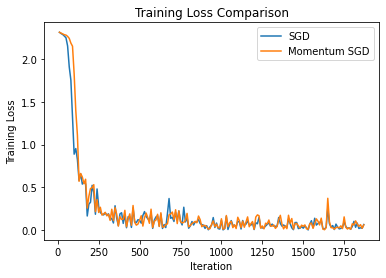

In [6]:
# Plot training loss and test accuracy
import matplotlib.pyplot as plt
iter_num = [ 10 * i for i in range(1, len(sgd_loss) + 1)]

# Plotting training loss
plt.plot(iter_num, sgd_loss, label="SGD")
plt.plot(iter_num, msgd_loss, label="Momentum SGD")
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.title("Training Loss Comparison")
plt.legend()
# Save the figure
plt.savefig("./result/Loss_batch_{}_lr_{:.4f}_momentum_{:.4f}.png".format(BATCH_SIZE, LR, MOMENTUM))
plt.show()

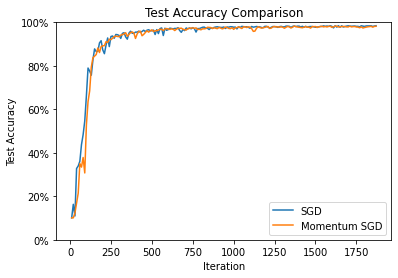

In [7]:
# Plotting test accuracy
from matplotlib.ticker import PercentFormatter
sgd_acc = [ 100 * i for i in sgd_acc]
msgd_acc = [ 100 * i for i in msgd_acc]
plt.plot(iter_num, sgd_acc, label="SGD")
plt.plot(iter_num, msgd_acc, label="Momentum SGD")
plt.xlabel("Iteration")
plt.ylabel("Test Accuracy")
plt.ylim(0, 100)
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.title("Test Accuracy Comparison")
plt.legend()
# Save the figure
plt.savefig("./result/Accuracy_batch_{}_lr_{:.4f}_momentum_{:.4f}.png".format(BATCH_SIZE, LR, MOMENTUM))
plt.show()
